In [26]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util #for paraphrase_mining
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import lightgbm as ltb
from sentence_transformers import SentenceTransformer
import nltk
import re

In [39]:
train = pd.read_csv(r'train.csv')
train["Крайний срок"] = pd.to_datetime(train["Крайний срок"], format='%Y-%m-%d %H:%M')
train["Дата обращения"] = pd.to_datetime(train["Дата обращения"], format='%Y-%m-%d %H:%M')
train["Дата закрытия обращения"] = pd.to_datetime(train["Дата закрытия обращения"], format='%Y-%m-%d %H:%M')
train = train.drop(4119)
train["Тип обращения итоговый 01"] = train["Тип обращения итоговый"].apply(lambda x: {"Запрос": 0, "Инцидент": 1}[x])
train.head()

,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,Тип переклассификации,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место,Тип обращения итоговый 01
0,Тест,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 07:42:00,2018-01-19 09:27:00,Запрос,Запрос,Тест,0,NaN,2018-01-19 09:43:00,4-Нет,3-Малое,База,К,0
1,Тестовое обращение,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 10:51:00,2018-01-19 09:36:00,Запрос,Запрос,Тест,0,NaN,2018-01-19 09:41:00,4-Нет,3-Малое,База,К,0
2,Выполнена разблокировка у/з REGION\*****,Сервис7,2-Средний,Закрыт,ФГ8,2018-01-31 07:51:00,2018-01-25 22:47:00,Запрос,Запрос,Выполнена разблокировка у/з Ne_bosS\*********\...,0,2018-01-25 22:47,2018-02-02 07:52:00,1-Особая,3-Малое,Система7,Место190,0
3,.Не включается ПК,АРМ,3-Низкий,Закрыт,ФГ390,2018-01-28 05:50:00,2018-01-25 23:13:00,Инцидент,Инцидент,Выход из стоя БП. Заменён.,0,2018-01-25 23:55,2018-01-26 00:00:00,4-Нет,3-Малое,База,Место177,1
4,"Заявка № ***********, *******************",АРМ,3-Низкий,Закрыт,ФГ303,2018-02-03 02:51:00,2018-01-25 23:39:00,Запрос,Запрос,Работы по обращению выполнены,0,2018-01-28 02:54,2018-02-04 07:53:00,4-Нет,4-Нет влияния,База,Место216,0


In [4]:
train["Дата закрытия обращения"].sort_values().dropna()

1       2018-01-19 09:41:00
0       2018-01-19 09:43:00
3       2018-01-26 00:00:00
19      2018-01-26 01:38:00
17      2018-01-26 02:13:00
                ...        
5622    2018-05-18 11:11:00
6518    2018-05-20 07:53:00
12255   2018-05-23 10:05:00
4183    2018-06-08 13:27:00
9717    2018-06-09 08:18:00
Name: Дата закрытия обращения, Length: 14426, dtype: datetime64[ns]

<Axes: >

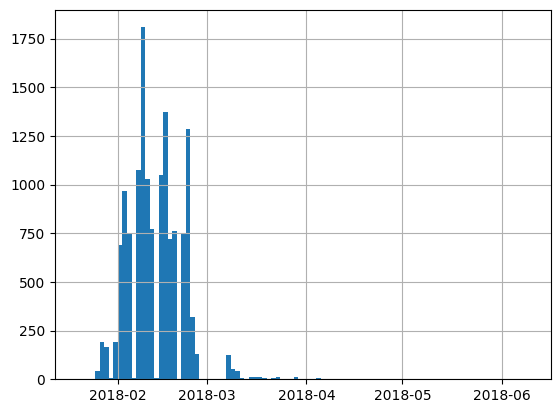

In [6]:
#train["Крайний срок"].hist(bins=100)
#train["Дата обращения"].hist(bins=100)
train["Дата закрытия обращения"].hist(bins=100)


In [17]:
i = 1

print(train[train['Тип переклассификации'] == i]['Тип обращения на момент подачи'].unique())
print(train[train['Тип переклассификации'] == i]['Тип обращения итоговый'].unique())


['Запрос']
['Инцидент']


In [18]:
df_0 = pd.DataFrame()
df_1 = pd.DataFrame()

df_0["text"] = train[train['Тип обращения итоговый'] == "Запрос"]["Содержание"]
df_1["text"] = train[train['Тип обращения итоговый'] == "Инцидент"]["Содержание"]



In [19]:
%%time
# 2018-01-19 09:43	


train["Дата обращения"]

CPU times: user 312 µs, sys: 25 µs, total: 337 µs
Wall time: 349 µs


0       2018-01-19 09:27:00
1       2018-01-19 09:36:00
2       2018-01-25 22:47:00
3       2018-01-25 23:13:00
4       2018-01-25 23:39:00
                ...        
14798   2018-02-16 13:02:00
14799   2018-02-16 13:07:00
14800   2018-02-16 13:08:00
14801   2018-02-16 13:09:00
14802   2018-02-16 13:10:00
Name: Дата обращения, Length: 14802, dtype: datetime64[ns]

In [11]:
train["Содержание"].apply(str)

0                                                     Тест
1                                       Тестовое обращение
2                 Выполнена разблокировка у/з REGION\*****
3                                        .Не включается ПК
4                Заявка № ***********, *******************
                               ...                        
14798     разблокировка учетной записи пользователя вСе...
14799    Устранение уязвимостей ИБ в соответствии с Пла...
14800              Контроль ПУ. Заявка на доступ к портам.
14801                                      Ремонт стульев.
14802    Заявка на предоставление и отзыв прав доступа ...
Name: Содержание, Length: 14802, dtype: object

In [12]:
%%time

#не использовать 

model_selection = pd.DataFrame(columns=['model', 'rmse_train'])

data_copy = train.copy()

model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
data_copy["Содержание_distiluse"] = data_copy["Содержание"].apply(str).apply(model.encode)

# data_copy.dropna(inplace=True)
data_copy["Тип обращения итоговый 01"] = data_copy["Тип обращения итоговый"].apply(lambda x: {"Запрос": 0, "Инцидент": 1}[x])


CPU times: user 1h 36min 17s, sys: 15.7 s, total: 1h 36min 32s
Wall time: 7min 19s


In [64]:
train_features

,Содержание_distiluse
0,"[0.0054264953, 0.03484664, -0.043095928, -0.00..."
1,"[-0.004410029, 0.045409504, -0.035607, 0.05434..."
2,"[0.0032631522, -0.031935878, -0.020486167, 0.0..."
3,"[-0.0003455198, -0.011863916, -0.009838245, -0..."
4,"[0.011684041, -0.016259423, -0.013979559, 0.02..."
...,...
10652,"[0.011684041, -0.016259423, -0.013979559, 0.02..."
10653,"[0.011684041, -0.016259423, -0.013979559, 0.02..."
10654,"[0.006826275, -0.013016901, -0.027685693, 0.03..."
10655,"[-0.025440272, 0.030161751, 0.012145033, -0.03..."


In [17]:
%%time


#разделим данные так, чтобы на test приходилось 10%, данные не перемешиваются
#нужно чтобы данные обновляли свои признаки
LGBMR_train, test = train_test_split(data_copy[["Содержание_distiluse", "Тип обращения итоговый 01"]], shuffle = False, test_size=0.1, random_state=12345)
LGBMR_train, valid = train_test_split(LGBMR_train, shuffle = False, test_size=0.2, random_state=12345)

train_features = LGBMR_train.drop('Тип обращения итоговый 01', axis=1)
train_target = LGBMR_train['Тип обращения итоговый 01']
test_features = test.drop('Тип обращения итоговый 01', axis=1)
test_target = test['Тип обращения итоговый 01']


#градиентный бустинг
for depth, est in zip(range(1, 15), range(1,100,10)):
    gradient_boosting = ltb.LGBMRegressor(max_depth=depth, n_estimators=est, learning_rate=0.1)
    gradient_boosting.fit(train_features, train_target)

    rmse_train = mean_squared_error(train_target, gradient_boosting.predict(train_features))**0.5
    rmse_valid = mean_squared_error(valid_target, gradient_boosting.predict(valid_features))**0.5
    model_selection.loc[len(model_selection)] = [gradient_boosting, rmse_train, rmse_valid]
        
#print(f'RMSE на train выборке: {rmse_train}')
#print(f'RMSE на test выборке: {rmse_test}')


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: Содержание_distiluse

In [36]:
train["Содержание"].apply(str)

0                                                     Тест
1                                       Тестовое обращение
2                 Выполнена разблокировка у/з REGION\*****
3                                        .Не включается ПК
4                Заявка № ***********, *******************
                               ...                        
14798     разблокировка учетной записи пользователя вСе...
14799    Устранение уязвимостей ИБ в соответствии с Пла...
14800              Контроль ПУ. Заявка на доступ к портам.
14801                                      Ремонт стульев.
14802    Заявка на предоставление и отзыв прав доступа ...
Name: Содержание, Length: 14802, dtype: object

In [27]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")

def token_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in
             nltk.word_tokenize(sent)] #разбиение на токены
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token): #удаление всего, кроме букв
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens] #стемминг
    return stems   

In [29]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [86]:
stopwords = nltk.corpus.stopwords.words("russian") 

from sklearn.feature_extraction.text import TfidfVectorizer
n_featur = 200_000

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=1_000,
                                  min_df=0.01, stop_words=stopwords,
                                  use_idf=True, tokenizer=token_and_stem)

In [89]:
train["Содержание"].tail(10)

14793                            Запрос на организацию БРМ
14794                     Разблокировать УЗ NE_BOSS\******
14795    Заявка на предоставление и отзыв прав доступа ...
14796    Заявка на предоставление и отзыв прав доступа ...
14797    Заявка на предоставление и отзыв прав доступа ...
14798     разблокировка учетной записи пользователя вСе...
14799    Устранение уязвимостей ИБ в соответствии с Пла...
14800              Контроль ПУ. Заявка на доступ к портам.
14801                                      Ремонт стульев.
14802    Заявка на предоставление и отзыв прав доступа ...
Name: Содержание, dtype: object

In [87]:
tfidf_matrix = tfidf_vectorizer.fit_transform(train["Содержание"].apply(str))


/jupyter/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TypeError: 'TfidfVectorizer' object is not subscriptable

In [68]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, train["Тип обращения итоговый 01"], test_size=0.2, random_state=1423)
x_train = x_train.toarray()
x_test = x_test.toarray()


In [69]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

clf_list = [LinearDiscriminantAnalysis(), KNeighborsClassifier(), GaussianNB(), DecisionTreeClassifier()]

for clf in clf_list:
    print(type(clf))
    clf.fit(x_train, y_train)

<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
<class 'sklearn.naive_bayes.GaussianNB'>
<class 'sklearn.tree._classes.DecisionTreeClassifier'>


In [70]:
for clf in clf_list:
    print(clf.score(tfidf_matrix.toarray(), train["Тип обращения итоговый 01"]))

0.9726388325901905
0.9726388325901905
0.05769490609377111
0.9726388325901905


In [57]:
y_train

12206    0
4145     0
4091     0
11200    0
8378     0
        ..
13124    0
3264     0
9846     0
10800    0
2732     0
Name: Тип обращения итоговый 01, Length: 11841, dtype: int64

In [58]:
x_train

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [60]:
y_test

5386     0
974      1
11251    0
1172     0
6808     0
        ..
7702     0
8388     0
11417    0
14304    0
5321     0
Name: Тип обращения итоговый 01, Length: 2961, dtype: int64

In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

for d in range(1, 200):
    model = DecisionTreeClassifier(max_depth=d)
    model.fit(x_train, y_train)
    p = model.predict(x_test)
    print(f'max_depth = {d} \t f1_score = {accuracy_score(y_test, p)}')

max_depth = 1 	 f1_score = 0.9685916919959473
max_depth = 2 	 f1_score = 0.9685916919959473
max_depth = 3 	 f1_score = 0.9685916919959473
max_depth = 4 	 f1_score = 0.9685916919959473
max_depth = 5 	 f1_score = 0.9685916919959473
max_depth = 6 	 f1_score = 0.9685916919959473
max_depth = 7 	 f1_score = 0.9685916919959473
max_depth = 8 	 f1_score = 0.9685916919959473
max_depth = 9 	 f1_score = 0.9685916919959473
max_depth = 10 	 f1_score = 0.9685916919959473
max_depth = 11 	 f1_score = 0.9685916919959473
max_depth = 12 	 f1_score = 0.9685916919959473
max_depth = 13 	 f1_score = 0.9685916919959473
max_depth = 14 	 f1_score = 0.9685916919959473
max_depth = 15 	 f1_score = 0.9685916919959473
max_depth = 16 	 f1_score = 0.9685916919959473
max_depth = 17 	 f1_score = 0.9685916919959473
max_depth = 18 	 f1_score = 0.9685916919959473
max_depth = 19 	 f1_score = 0.9685916919959473
max_depth = 20 	 f1_score = 0.9685916919959473
max_depth = 21 	 f1_score = 0.9685916919959473
max_depth = 22 	 f1_sc

In [44]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4)

[[1,2,3,4,5],
]